# **F1 레이싱 드라이버 및 팀별 성적 변화 분석 (EDA & 데이터 전처리 중심)**

> **분석 목적(목표)**:
```
F1 경기 데이터를 활용하여 드라이버 및 팀별 성적 변화를 탐색하고, 데이터 전처리 및 EDA를 통해 다양한 패턴을 분석해보는 연습을 진행
```


예시 1. 특정 드라이버 선수들의 연도별 성적 변화 확인:
- 특정 드라이버가 어떤 연도에 성적이 상승/하락했는지

예시 2. 팀별 누적 포인트 및 순위 변화 분석:
-  특정 팀(페라리, 레드불 등)이 어느 시기에 강세였는지 분석

## **TASK 1. 데이터 출처 설명 / 데이터 불러오기**

**기본 라이브러리 세팅**

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline

In [166]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**분석에 필요한 데이터셋 선별하여 불러오기**

> 내가 분석할 것은 드라이버 및 팀별 성적 변화이기에 필요한 경기, 선수, 팀별 데이터셋만 불러오도록 한다.

In [167]:
races = pd.read_csv('/content/drive/MyDrive/EPOCH/races.csv')
drivers = pd.read_csv('/content/drive/MyDrive/EPOCH/drivers.csv')
constructors = pd.read_csv('/content/drive/MyDrive/EPOCH/constructors.csv')
results = pd.read_csv('/content/drive/MyDrive/EPOCH/results.csv')
qualifying = pd.read_csv('/content/drive/MyDrive/EPOCH/qualifying.csv')

print(f"races: {races.shape}, drivers: {drivers.shape}, constructors: {constructors.shape}")
print(f"results: {results.shape}, qualifying: {qualifying.shape}")

races: (1125, 18), drivers: (861, 9), constructors: (212, 5)
results: (26759, 18), qualifying: (10494, 9)


### **Dataset 주요 컬럼 설명**  
> **데이터 출처:** [Ergast API Formula 1 Dataset](https://ergast.com/mrd/db/)

#### **races.csv (경기 정보)**
| 컬럼명 | 설명 |
|--------|-------------------------------|
| `raceId` | 경기 고유 ID |
| `year` | 경기 연도 |
| `round` | 시즌 내 경기 라운드 번호 |
| `circuitId` | 경기장이 위치한 서킷 ID |
| `name` | 경기명 (예: British Grand Prix) |
| `date` | 경기 날짜 |

---

#### **drivers.csv (드라이버 정보)**
| 컬럼명 | 설명 |
|--------|-------------------------------|
| `driverId` | 드라이버 고유 ID |
| `driverRef` | 드라이버 참조 ID (고유 문자열) |
| `number` | 드라이버의 차량 번호 |
| `code` | 드라이버 코드 (예: HAM - Lewis Hamilton) |
| `forename` | 드라이버 이름 |
| `surname` | 드라이버 성 |
| `dob` | 드라이버 생년월일 |
| `nationality` | 드라이버 국적 |

---

#### **constructors.csv (팀 정보)**
| 컬럼명 | 설명 |
|--------|-------------------------------|
| `constructorId` | 팀(컨스트럭터) 고유 ID |
| `constructorRef` | 팀 참조 ID (고유 문자열) |
| `name` | 팀명 (예: Ferrari, Mercedes) |
| `nationality` | 팀 국적 |

---

#### **results.csv (경기 결과)**
| 컬럼명 | 설명 |
|--------|-------------------------------|
| `resultId` | 경기 결과 고유 ID |
| `raceId` | 경기 ID (races.csv와 연결) |
| `driverId` | 드라이버 ID (drivers.csv와 연결) |
| `constructorId` | 팀 ID (constructors.csv와 연결) |
| `grid` | 출발 순위 (예선 결과 기반) |
| `position` | 최종 경기 순위 |
| `points` | 경기에서 획득한 점수 |
| `laps` | 완주한 랩 수 |
| `time` | 최종 경기 기록 |
| `fastestLap` | 가장 빠른 랩 기록한 랩 번호 |
| `fastestLapTime` | 해당 랩에서의 기록 |

---

#### **qualifying.csv (예선 결과)**
| 컬럼명 | 설명 |
|--------|-------------------------------|
| `qualifyId` | 예선 결과 고유 ID |
| `raceId` | 경기 ID |
| `driverId` | 드라이버 ID |
| `constructorId` | 팀 ID |
| `position` | 예선 최종 순위 (1위가 폴 포지션) |
| `q1` | 1차 예선 기록 |
| `q2` | 2차 예선 기록 |
| `q3` | 3차 예선 기록 |

---

## **Task 2. 기초 통계 확인**

### **우선 데이터를 병합하여 종합적인 판단이 가능하도록 만들어 준다.**

`.merge()`는 SQL의 JOIN과 같은 개념

> 사용된 공통 키(`key`):
* raceId
* driverId
* constructorId

In [168]:
# (경기 결과 + 드라이버 정보 + 팀 정보 + 경기 정보)
# 병합하여 사용
# Why?:
# 각각의 F1 데이터셋만으로는 종합적인 분석이 어렵고, 연관성을 파악하기 힘들다.
# 그래서 데이터를 병합함으로써 경기 결과, 연도, 서킷, 드라이버, 팀, 예선 성적 등을 "종합적으로" 함께 볼 수 있도록 만들어준 것!

df = results.merge(races[['raceId', 'year', 'circuitId']], on='raceId', how='left')
df = df.merge(drivers[['driverId', 'surname', 'nationality']], on='driverId', how='left')
df = df.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')
df = df.merge(qualifying[['raceId', 'driverId', 'constructorId', 'position']],
              on=['raceId', 'driverId', 'constructorId'],
              how='left', suffixes=('', '_qualifying'))

### **기초 통계**

In [169]:
df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,rank,fastestLapTime,fastestLapSpeed,statusId,year,circuitId,surname,nationality,name,position_qualifying
0,1,18,1,1,22,1,1,1,1,10.0,...,2,1:27.452,218.300,1,2008,1,Hamilton,British,McLaren,1.0
1,2,18,2,2,3,5,2,2,2,8.0,...,3,1:27.739,217.586,1,2008,1,Heidfeld,German,BMW Sauber,5.0
2,3,18,3,3,7,7,3,3,3,6.0,...,5,1:28.090,216.719,1,2008,1,Rosberg,German,Williams,7.0
3,4,18,4,4,5,11,4,4,4,5.0,...,7,1:28.603,215.464,1,2008,1,Alonso,Spanish,Renault,12.0
4,5,18,5,1,23,3,5,5,5,4.0,...,1,1:27.418,218.385,1,2008,1,Kovalainen,Finnish,McLaren,3.0



- **raceId, driverId, constructorId** → F1 경기, 드라이버, 팀을 나타내는 고유
 ID  (식별키)
- **grid** → 드라이버의 예선 출발 순위 (0부터 시작)  
- **position, position_qualifying** → 경기 최종 순위와 예선 순위 비교 가능  
- **points** → 경기에서 획득한 점수  
- **year, circuitId** → 경기 연도와 서킷 정보  
- **surname, name** → 드라이버 성과 팀명  
- **fastestLapTime, fastestLapSpeed** → 경기 중 가장 빠른 랩 정보  


In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   resultId             26759 non-null  int64  
 1   raceId               26759 non-null  int64  
 2   driverId             26759 non-null  int64  
 3   constructorId        26759 non-null  int64  
 4   number               26759 non-null  object 
 5   grid                 26759 non-null  int64  
 6   position             26759 non-null  object 
 7   positionText         26759 non-null  object 
 8   positionOrder        26759 non-null  int64  
 9   points               26759 non-null  float64
 10  laps                 26759 non-null  int64  
 11  time                 26759 non-null  object 
 12  milliseconds         26759 non-null  object 
 13  fastestLap           26759 non-null  object 
 14  rank                 26759 non-null  object 
 15  fastestLapTime       26759 non-null 

In [171]:
df.describe()

,resultId,raceId,driverId,constructorId,grid,positionOrder,points,laps,statusId,year,circuitId,position_qualifying
count,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,10484.000000
mean,13380.977391,551.687283,278.673530,50.180537,11.134796,12.794051,1.987632,46.301768,17.224971,1991.394372,23.820808,11.188668
std,7726.134642,313.265036,282.703039,61.551498,7.202860,7.665951,4.351209,29.496557,26.026104,19.952885,19.112002,6.259034
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1950.000000,1.000000,1.000000
25%,6690.500000,300.000000,57.000000,6.000000,5.000000,6.000000,0.000000,23.000000,1.000000,1977.000000,9.000000,6.000000
50%,13380.000000,531.000000,172.000000,25.000000,11.000000,12.000000,0.000000,53.000000,10.000000,1991.000000,18.000000,11.000000
75%,20069.500000,811.000000,399.500000,63.000000,17.000000,18.000000,2.000000,66.000000,14.000000,2009.000000,34.000000,16.000000
max,26764.000000,1144.000000,862.000000,215.000000,34.000000,39.000000,50.000000,200.000000,141.000000,2024.000000,80.000000,28.000000



### **기초 통계를 통한 데이터 이해 결과 (+ F1에 대한 이해)**

```
데이터 크기 및 연도 범위
```
- **year 컬럼**  
  - 최소값: 1950년, 최대값: 2024년 → 엄청 오래 전부터 있었음
- **전체 데이터 수**  
  - 26,759개 경기 기록 → 데이터 개수는 적지 않아 보임 good

```
순위 및 예선 데이터 (position, position_qualifying)
```
- **position (최종 경기 순위)**  
  - 최소값: 1, 최대값: 39  
  - 일반적으로 1~20위까지가 정상이므로, 20위 초과값 확인 필요  
- **position_qualifying (예선 순위)**  
  - 데이터 개수: 10,484개 → 예선 정보가 없는 경우가 많음 (결측치 처리 필요)  

```
출발 순위 (grid)
```
- **grid**  
  - 최소값: 0, 최대값: 34  
  - 출발 순위가 0인 경우 확인 필요 (예외적인 케이스일 가능성)
  - 출발 순서는 아주 중요하다고 함, 가장 앞에 설수록 첫 번째 코너에 가장 빨리 도달할 가능성이 높기 때문  
  - 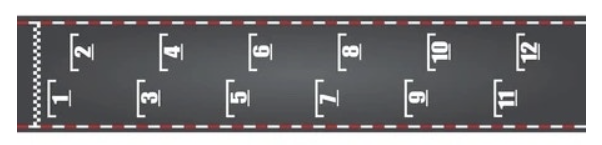

```
포인트 (points)
```
- **points**  
  - F1 경기에서 드라이버가 레이스에서 획득하는 점수
  - 최소값: 0, 최대값: 50  
  - 포인트 배점 시스템은 시대별로 다르므로, 연도별 포인트 시스템 차이를 고려한 표준화가 필요할 것으로 보임
  - 평균 포인트: 1.98 → 상위권 드라이버와 하위권 드라이버의 점수 차이가 극명할 가능성 있음  
  - F1 포인트 제도 규칙: https://m.blog.naver.com/pho2074/223364967685

```
랩 관련 데이터 (laps, fastestLapTime, fastestLapSpeed)
```
- **laps (완주 랩 수)**  
  - 최소값: 0, 최대값: 200  
  - 일부 경기가 랩을 다 돌지 못했거나 데이터 오류일 가능성 있음  
- **fastestLapTime 및 fastestLapSpeed**  
  - 특정 경기에서만 기록됨 (결측치 처리 필요)  

```
결측치 (position_qualifying)
```
- **position_qualifying**  


### **수치형/범주형 분석**

In [172]:
int_col = df.select_dtypes(include=['int64', 'float64'])
obj_col = df.select_dtypes(include=['object'])

In [173]:
int_col.describe()

,resultId,raceId,driverId,constructorId,grid,positionOrder,points,laps,statusId,year,circuitId,position_qualifying
count,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,10484.000000
mean,13380.977391,551.687283,278.673530,50.180537,11.134796,12.794051,1.987632,46.301768,17.224971,1991.394372,23.820808,11.188668
std,7726.134642,313.265036,282.703039,61.551498,7.202860,7.665951,4.351209,29.496557,26.026104,19.952885,19.112002,6.259034
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1950.000000,1.000000,1.000000
25%,6690.500000,300.000000,57.000000,6.000000,5.000000,6.000000,0.000000,23.000000,1.000000,1977.000000,9.000000,6.000000
50%,13380.000000,531.000000,172.000000,25.000000,11.000000,12.000000,0.000000,53.000000,10.000000,1991.000000,18.000000,11.000000
75%,20069.500000,811.000000,399.500000,63.000000,17.000000,18.000000,2.000000,66.000000,14.000000,2009.000000,34.000000,16.000000
max,26764.000000,1144.000000,862.000000,215.000000,34.000000,39.000000,50.000000,200.000000,141.000000,2024.000000,80.000000,28.000000


**📌수치형 변수 (int, float) 정리**  

- **`resultId`**: 개별 경기 결과를 나타내는 고유 ID → **통계적으로 의미 없음**  
- **`raceId`, `driverId`, `constructorId`**: 경기, 드라이버, 팀을 식별하는 고유 ID → **통계적으로 의미 없음**  
- **`grid` (출발 순위)**: **0~34**, 평균 **11.13** → 출발 순위가 경기 결과에 미치는 영향 분석 가능  
- **`positionOrder` (최종 순위)**: **1~39**, 평균 **12.79** → 일반적으로 1~20위가 주요 분석 대상, 20위 이상 값 확인 필요  
- **`points` (획득 포인트)**: **0~50**, 평균 **1.98** → **포인트 시스템 변화 고려 필요**, 이상값 확인 필요  
- **`laps` (완주 랩 수)**: **0~200**, 평균 **46.30** → **0 랩(DNF) 데이터 확인 필요**  
- **`statusId` (경기 상태 코드)**: **1~141**, 경기 상태를 나타내는 코드 → 해석 필요  
- **`year` (경기 연도)**: **1950~2024** → **시대별 변화 분석 가능**  
- **`circuitId` (서킷 ID)**: **1~80** → 서킷별 경기 성적 비교 가능  
- **`position_qualifying` (예선 순위)**: **1~28**, 평균 **11.18** → 예선 성적이 최종 결과에 미치는 영향 분석 가능, 결측치 많음 (약 16,000개)  


In [174]:
obj_col.describe()

,number,position,positionText,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,surname,nationality,name
count,26759,26759,26759,26759,26759,26759,26759,26759,26759,26759,26759,26759
unique,130,34,39,7411,7639,81,26,7474,7725,802,43,211
top,4,\N,R,\N,\N,\N,\N,\N,\N,Schumacher,British,Ferrari
freq,1019,10953,8897,19079,19079,18507,18249,18507,18507,532,4559,2439


**📌 범주형 변수(object) 정리**  

- **`position` (최종 순위, 문자열로 저장됨)**: **34개의 고유값** 존재 → `\N` 값이 많음(10953개), **숫자로 변환 필요**  
- **`positionText` (순위 표시값)**: **"R"(리타이어)가 가장 많음(8897개)** → **DNF(완주 실패) 여부를 새로운 변수로 생성 가능**  
- **`time` (최종 경기 시간)**: **7,411개의 고유값, `\N`이 19,079개** → 시간 데이터 변환 필요, `\N` 값 처리 필요  
- **`milliseconds` (밀리초 단위 경기 기록)**: **7,639개의 고유값, `\N`이 19,079개** → 숫자로 변환 필요, 결측치 처리 필요  
- **`fastestLap` (가장 빠른 랩 기록한 랩 번호)**: **81개의 고유값, `\N`이 18,507개** → 사용 여부 판단 필요, 결측치 처리  
- **`rank` (패스티스트 랩 순위)**: **26개의 고유값, `\N`이 18,249개** → 숫자로 변환 가능, 결측치 많음  
- **`fastestLapTime` (최고 랩타임, 현재 데이터 없음)**: **데이터가 전부 결측치(0개 존재)** → 제거 가능  
- **`fastestLapSpeed` (최고 랩 속도)**: **7,725개의 고유값, `\N`이 18,507개** → 숫자로 변환 필요  
- **`nationality` (드라이버 국적)**: **43개의 고유값, 가장 많은 국적: British (4559명)** → 머신러닝 학습 시 원-핫 인코딩 고려 가능  
- **`name` (드라이버 + 팀명 조합)**: **2,125개의 고유값, 가장 많이 등장한 값: "Hamilton Mercedes" (246번)** → 드라이버별 성적 변화 분석 가능  


### **약간의 전처리**

> 기초 통계를 통해 얻은 정보를 기반으로

누락값, 고유값 확인

In [175]:
print(df.isnull().sum())

resultId                   0
raceId                     0
driverId                   0
constructorId              0
number                     0
grid                       0
position                   0
positionText               0
positionOrder              0
points                     0
laps                       0
time                       0
milliseconds               0
fastestLap                 0
rank                       0
fastestLapTime             0
fastestLapSpeed            0
statusId                   0
year                       0
circuitId                  0
surname                    0
nationality                0
name                       0
position_qualifying    16275
dtype: int64


In [176]:
print(df.nunique())

resultId               26759
raceId                  1125
driverId                 861
constructorId            211
number                   130
grid                      35
position                  34
positionText              39
positionOrder             39
points                    39
laps                     172
time                    7411
milliseconds            7639
fastestLap                81
rank                      26
fastestLapTime          7474
fastestLapSpeed         7725
statusId                 137
year                      75
circuitId                 77
surname                  802
nationality               43
name                     211
position_qualifying       28
dtype: int64


In [177]:
# 결측치 처리
# 예선 순위를 의미하는 position_qualifying이 없는 경우 -1로 대체
df['position_qualifying'].fillna(-1, inplace=True)

In [178]:
# 중복 데이터 제거
# 결과가 0이면 데이터 중복 없음 의미
df.duplicated().sum()

0

sur name과 name은 굳이 따로 있을 필요없으니 합쳐서 'name'으로 만들어주자.

In [179]:
df['name'] = df['surname'] + " " + df['name']
df.drop(columns=['surname'], inplace=True)
print(df[['name']].head())  # 변경된 컬럼 확인


                  name
0     Hamilton McLaren
1  Heidfeld BMW Sauber
2     Rosberg Williams
3       Alonso Renault
4   Kovalainen McLaren


`fastestLapTime` (최고 랩타임) → 숫자로 변환

In [180]:
def convert_time_to_seconds(time_str):
    try:
        minutes, seconds = time_str.split(":")
        return float(minutes) * 60 + float(seconds)
    except:
        return None

df['fastestLapTime'] = df['fastestLapTime'].apply(convert_time_to_seconds)

` number` (차량 번호) → 필요 없음

In [181]:
df.drop(columns=['number'], inplace=True)

In [182]:
# 다시 중간 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   resultId             26759 non-null  int64  
 1   raceId               26759 non-null  int64  
 2   driverId             26759 non-null  int64  
 3   constructorId        26759 non-null  int64  
 4   grid                 26759 non-null  int64  
 5   position             26759 non-null  object 
 6   positionText         26759 non-null  object 
 7   positionOrder        26759 non-null  int64  
 8   points               26759 non-null  float64
 9   laps                 26759 non-null  int64  
 10  time                 26759 non-null  object 
 11  milliseconds         26759 non-null  object 
 12  fastestLap           26759 non-null  object 
 13  rank                 26759 non-null  object 
 14  fastestLapTime       8252 non-null   float64
 15  fastestLapSpeed      26759 non-null 

## **TASK 3: 분석 목적/인사이트 (추가)**
> **데이터셋을 확인하는 과정에서 추가된 데이터 분석 인사이트를 몇 가지 더 정리해보았다.**

- 포인트 분포를 보면 대부분의 드라이버가 0점이며, 극소수만 높은 점수를 받음
  - 머신러닝에서 다룰 때 포인트를 직접 예측하기보다는 상위권(Top 3) 예측이 더 유리할 수도 있음

- 출발 순위(grid)와 최종 순위(position) 간의 관계 분석 가능
  - 출발 순위가 좋은 드라이버가 반드시 경기에서 좋은 성적을 내는지 분석

- 연도별 평균 포인트 분석을 통해, 시대별 규칙 변화 확인 가능
  - 특정 연도(예: 2010년 이후)부터 상위 10명에게 포인트가 부여됨을 데이터로 확인 가능


> 느낀 점

- 생각보다 F1 규칙이 많이 낯설고 까다로워서 제대로 된 EDA와 패턴 분석을 해보기 위해서는 규칙에 대한 이해가 무조건 숙지되어야 할 것 같다.

- 데이터 자체는 결측치도 적당히 있고, 양도 충분한 편, 괜찮아 보인다.

- 지금 컬럼 수가 좀 많은 것 같긴 하다;; 차라리 데이터셋 개수를 더 줄이고 컬럼 수도 더 줄여서, 딱 내가 원하는 인사이트 도출 1~2개만을 위해 계획을 간소화하는 방안 다음주까지 고려.